<a href="https://colab.research.google.com/github/sdenyskov/sd995_ads_2024/blob/main/notebooks/02-access-assess-geospatial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical 2

### [Radzim Sendyka](https://www.cst.cam.ac.uk/people/rs2071), University

of Cambridge

### [Christian Cabrera](https://www.cst.cam.ac.uk/people/chc79), University

of Cambridge

### [Carl Henrik Ek](http://carlhenrik.com), University of Cambridge

### [Neil D. Lawrence](http://inverseprobability.com), University of

Cambridge

### 2024-11-07

**Abstract**: In this lab session we look at working with geospatial
data, in conjunction with the house prices dataset you created in the
previous practicals.

$$
$$

::: {.cell .markdown}

<!-- Do not edit this file locally. -->
<!-- Do not edit this file locally. -->
<!---->
<!-- Do not edit this file locally. -->
<!-- Do not edit this file locally. -->
<!-- The last names to be defined. Should be defined entirely in terms of macros from above-->
<!--

-->

**The check Session for this Practical is 12th November 2024.**
Prerequisite: practical 1, and a working database with tables price paid
data (i.e., `pp_data`) and postcodes(i.e., `postcode_data`)

In this lab session we look at working with geospacial data, in
conjunction with the house prices dataset you created in the previous
practicals. The goal is to enrich the data from the first practical with
geographic data enabling better informed data analysis. Access to the
price paid database is needed to complete some of the below exercises.
You are asked to write reusable code that will help you in the
assessment.

## Accessing Open Street Maps

<span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/snippets/edit/main/_datasets/includes/accessing-osm.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/snippets/edit/main/_datasets/includes/accessing-osm.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

[Open Street Maps
(OSM)](https://www.openstreetmap.org/#map=6/54.91/-3.43) is an open
geographic database that can provide useful information about different
locations and places in the planet. In this example, we will download
data about the city of Kampala, Uganda. As always, we should start by
installing some Python packages.

In [ ]:
%pip install osmnx
%pip uninstall --yes matplotlib
%pip install matplotlib==3.7.1

In [463]:
import osmnx as ox
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='osmnx')

We will download data of Kamplala, Uganda, which has the following
latitude and longitude.

In [464]:
place_name = "Kampala, Uganda"

latitude = 0.347596 # Kampala latitude
longitude = 32.582520 # Kampala longitude

In [465]:
placestub = place_name.lower().replace(' ', '-').replace(',','')

We’ll create a bounding box which is 0.02 degrees wide, 1 degree is
around 111km ([circumference of the Earth is around 40,000
km](https://en.wikipedia.org/wiki/Metre) and 40,000/360=111km). Note:
will this approximation work well in all countries?

In [466]:
box_width = 0.02 # About 2.2 km
box_height = 0.02
north = latitude + box_height/2
south = latitude - box_width/2
west = longitude - box_width/2
east = longitude + box_width/2

Now we’ll download a set of points of interest from OpenStreetMap. We
can specify the points of interest we’re interested in by building a
small dictionary containing their labels as follows. A Point of Interest
is a location with certain importance in the geographic area. They can
vary from amenities to touristic places as you can see in the following.

In [467]:
# Retrieve POIs
tags = {
    "amenity": True,
    "buildings": True,
    "historic": True,
    "leisure": True,
    "shop": True,
    "tourism": True,
    "religion": True,
    "memorial": True
}

We can use `osmnx` to download all such points of interest within a
given bounding box.

In [ ]:
pois = ox.geometries_from_bbox(north, south, east, west, tags)

That operation can take some time, particularly as the bounding box
grows larger. Once it is complete we can check how many points of
interest we have found.

In [ ]:
print("There are {number} points of interest surrounding {placename} latitude: {latitude}, longitude: {longitude}".format(number=len(pois), placename=place_name, latitude=latitude, longitude=longitude))

And then we can examine their contents in more detail.

In [ ]:
pois

### We notice a few things:

1.  Points of interest do not have a consistent OpenStreetMap
    `element_type`, some are `node`, others are `relation` and we also
    have `way`. You can find out more about elements in OpenStreetMap on
    [this wiki page](https://wiki.openstreetmap.org/wiki/Elements). This
    will become important when tidying up the data for next stage
    processing.

2.  Many of the values are missing. In SQL we would express a missing
    value as `NULL`. But in `pandas` a missing value is expressed as
    not-a-number, `NaN`. This is quite a common standard, but it is not
    the only standard. Sometimes data is collected and coded with an
    “unreasonable” value for a missing value. For example, someone might
    set missing values for heights to -999. The concept is that this is
    an obviously void “height” and would trigger a human user to check
    whether it’s a missing value. Of course, this is obvious to humans,
    but not necessarily to a computer!

Nodes, ways and relations in OpenStreetMap all have different *keys*
associated with them. The data is not structured in standard database
columns. Different points of interest might have different keys present
or absent. We might be interested in the following keys.

In [471]:
keys = ["name",
        "addr:city",
        "addr:postcode",
        "amenity",
        "building",
        "building:name",
        "building:colour",
        "building:material",
        "historic",
        "memorial",
        "religion",
        "tourism",
        "emergency",
        "leisure",
        "shop"]

But our downloaded `gdf` may have fewer keys.

In [ ]:
pois.columns.values

We can write a short piece of code to discover which keys are missing
drom the data frame’s columns.

In [ ]:
for key in keys:
    if key not in pois.columns:
        print(key)

present_keys = [key for key in keys if key in pois.columns]
pois[present_keys]

This gives us the relevant points of interest (part of the map). If we’d
like to see the entire street network, we can download the entire graph
from the location.

In [ ]:
graph = ox.graph_from_bbox(north, south, east, west)

# Retrieve nodes and edges
nodes, edges = ox.graph_to_gdfs(graph)

# Get place boundary related to the place name as a geodataframe
area = ox.geocode_to_gdf(place_name)

Which we can then render as follows.

In [ ]:
import matplotlib.pyplot as plt

%pip install --upgrade matplotlib

In [ ]:
fig, ax = plt.subplots()

# Plot the footprint
area.plot(ax=ax, facecolor="white")

# Plot street edges
edges.plot(ax=ax, linewidth=1, edgecolor="dimgray")

ax.set_xlim([west, east])
ax.set_ylim([south, north])
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

# Plot all POIs
pois.plot(ax=ax, color="blue", alpha=0.7, markersize=10)
plt.tight_layout()

In [ ]:
# Plot a subset of the POIs (e.g., tourist places)
# Create figure
fig, ax = plt.subplots()

# Plot the footprint
area.plot(ax=ax, facecolor="white")

# Plot street edges
edges.plot(ax=ax, linewidth=1, edgecolor="dimgray")

ax.set_xlim([west, east])
ax.set_ylim([south, north])
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

# Plot tourist places
tourist_places = pois[pois.tourism.notnull()]
tourist_places.plot(ax=ax, color="blue", alpha=1, markersize=50)
plt.tight_layout()

We have the POI information on all tourist places structured in a
geodataframe. To work with them in a machine learning algorithm, it will
be easier to convert them to a pandas DataFrame.

In [478]:
import pandas as pd

In [ ]:
pois_df = pd.DataFrame(pois)
pois_df['latitude'] = pois_df.apply(lambda row: row.geometry.centroid.y, axis=1)
pois_df['longitude'] = pois_df.apply(lambda row: row.geometry.centroid.x, axis=1)

tourist_places_df = pois_df[pois_df.tourism.notnull()]
print(len(tourist_places_df))
tourist_places_df

In [ ]:
poi_counts = {}

poi_types =["amenity", "historic", "leisure", "shop", "tourism", "religion", "memorial"]

for tag in poi_types:
  if tag in pois_df.columns:
    poi_counts[tag] = pois_df[tag].notnull().sum()
  else:
    poi_counts[tag] = 0

poi_counts_df = pd.DataFrame(list(poi_counts.items()), columns=['POI Type', 'Count'])



poi_counts_df

## Assessing the Available OpenStreetMap Features

<span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/snippets/edit/main/_datasets/includes/assessing-osm.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/snippets/edit/main/_datasets/includes/assessing-osm.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

In the course assessment you will be given the task of constructing a
prediction system for various indicators at a given location. We expect
that knowledge of the local region around the property should be helpful
in making those predictions. To evaluate this we will now look at
[OpenStreetMap](https://www.openstreetmap.org) as a data source.

In this section, you should follow the methodology used in the above
example to extract summary OSM information that can be useful in making
predictions about an area. Use code from the example to construct a
function that summarises the number of various points of interest in a
target area. You should write reusable code that allows you to explore
the characteristics of different points of interest.

In [481]:
def count_pois_near_coordinates(latitude: float, longitude: float, tags: dict, distance_km: float = 1.0) -> dict:
    """
    Count Points of Interest (POIs) near a given pair of coordinates within a specified distance.
    Args:
        latitude (float): Latitude of the location.
        longitude (float): Longitude of the location.
        tags (dict): A dictionary of OSM tags to filter the POIs (e.g., {'amenity': True, 'tourism': True}).
        distance_km (float): The distance around the location in kilometers. Default is 1 km.
    Returns:
        dict: A dictionary where keys are the OSM tags and values are the counts of POIs for each tag.
    """
    
    distance = distance_km / 111
    north = latitude + distance
    south = latitude - distance
    west = longitude - distance
    east = longitude + distance

    pois = ox.geometries_from_bbox(north, south, east, west, tags)
    pois_df = pd.DataFrame(pois)
    
    poi_counts = {}
    for tag, value in tags.items():
        if tag in pois_df.columns:
            if value is True:
                # count all POIs for this tag
                poi_counts[tag] = pois_df[tag].notnull().sum()
            elif isinstance(value, list):
                # count POIs that match one of the list values
                poi_counts[tag] = pois_df[tag].isin(value).sum()
            else:
                # raise an error
                raise ValueError(f"Unexpected value: tags[{tag}] = {value}")
        else:
            poi_counts[tag] = 0
    
    return poi_counts

Now that you have written reusable code, choose the tags you want to
query. This should be different from the tags used in the example. You
can also search for specific tags like this:
`"amenity": ["university", ...`.

In [482]:
tags = {
    "amenity": True,
    "historic": True,
    "leisure": True,
    "shop": True,
    "sport": ["tennis", "soccer", "squash", "multi", "bowls"],
    "tourism": True,
    "healthcare": True,
}

Here there are 13 UK locations.

In [483]:
locations_dict = {
    "Cambridge": (52.2054, 0.1132),
    "Oxford": (51.7570, -1.2545),
    "Euston Square": (51.5246, -0.1340),
    "Temple": (51.5115, -0.1160),
    "Kensington": (51.4988, -0.1749),
    "Barnsley": (53.5526, -1.4797),
    "Mansfield": (53.1472, -1.1987),
    "Wakefield": (53.6848, -1.5039),
    "Sunderland": (54.9069, -1.3838),
    "Rotherham": (53.4300, -1.3568),
    "Doncaster": (53.5228, -1.1288),
    "Chesterfield": (53.2350, -1.4210),
    "Huddersfield": (53.6450, -1.7794)
    }

### Exercise 1

Use your code to query the OSM feature counts for each of them, and
combine them into one dataframe.

### Exercise 1 Answer

#### Answer

In [ ]:
osm_feature_counts = {header: [] for header in ["location"] + list(tags.keys())}

for location, coords in locations_dict.items():

    latitude, longitude = coords[0], coords[1]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        poi_counts = count_pois_near_coordinates(latitude, longitude, tags)

    osm_feature_counts["location"].append(location)
    for tag, poi_count in poi_counts.items():
        osm_feature_counts[tag].append(poi_count)
    
    print(f"Location {location} has been processed.")

osm_feature_counts_df = pd.DataFrame(osm_feature_counts)

In [ ]:
osm_feature_counts_df

### Exercise 2

Use k-means clustering or another clustering method to try to find
clusters of similar areas, based on nearby OSM features.

### Exercise 2 Answer

#### Installs and imports

In [ ]:
%pip install scikit-learn

In [530]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

#### Clustering and results

In [1115]:
def kmeans_clusters(df, n_clusters, normalise):

    data = df.copy().drop(columns=['location'])

    if normalise:
        scaler = MinMaxScaler()
        scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    else:
        scaled_data = data
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(scaled_data)
    clusters = kmeans.labels_

    return clusters

In [1116]:
def extend_feature_df(df, locations_dict, clusters):
    
    latitudes = [locations_dict[location][0] for location in locations_dict]
    longitudes = [locations_dict[location][1] for location in locations_dict]

    to_concat = pd.DataFrame({"latitude": latitudes, "longitude": longitudes, "cluster": clusters})
    result = pd.concat([df, to_concat], axis=1)

    return result

In [1118]:
clusters = kmeans_clusters(df = osm_feature_counts_df, n_clusters = 3, normalise = False)
osm_feature_counts_df_clus = extend_feature_df(df = osm_feature_counts_df, locations_dict = locations_dict, clusters = clusters)

clusters = kmeans_clusters(df = osm_feature_counts_df, n_clusters = 3, normalise = True)
osm_feature_counts_df_clus_norm = extend_feature_df(df = osm_feature_counts_df, locations_dict = locations_dict, clusters = clusters)

In [1119]:
osm_feature_counts_df_clus.sort_values(by='cluster')

,location,amenity,historic,leisure,shop,sport,tourism,healthcare,latitude,longitude,cluster
5,Barnsley,365,4,54,314,7,12,17,53.5526,-1.4797,0
6,Mansfield,368,9,51,310,18,12,18,53.1472,-1.1987,0
7,Wakefield,445,2,60,382,18,11,20,53.6848,-1.5039,0
9,Rotherham,238,1,37,173,4,3,16,53.4300,-1.3568,0
10,Doncaster,273,3,20,220,3,15,4,53.5228,-1.1288,0
11,Chesterfield,346,1,29,271,3,13,10,53.2350,-1.4210,0
12,Huddersfield,382,8,22,290,5,11,6,53.6450,-1.7794,0
2,Euston Square,2141,109,121,591,8,171,65,51.5246,-0.1340,1
3,Temple,1881,112,97,516,6,172,27,51.5115,-0.1160,1
0,Cambridge,1137,27,200,271,25,82,9,52.2054,0.1132,2


In [1120]:
osm_feature_counts_df_clus_norm.sort_values(by='cluster')

,location,amenity,historic,leisure,shop,sport,tourism,healthcare,latitude,longitude,cluster
6,Mansfield,368,9,51,310,18,12,18,53.1472,-1.1987,0
7,Wakefield,445,2,60,382,18,11,20,53.6848,-1.5039,0
0,Cambridge,1137,27,200,271,25,82,9,52.2054,0.1132,1
1,Oxford,1158,73,242,325,22,120,13,51.7570,-1.2545,1
2,Euston Square,2141,109,121,591,8,171,65,51.5246,-0.1340,1
3,Temple,1881,112,97,516,6,172,27,51.5115,-0.1160,1
4,Kensington,1073,61,118,307,10,114,26,51.4988,-0.1749,1
5,Barnsley,365,4,54,314,7,12,17,53.5526,-1.4797,2
8,Sunderland,775,7,39,258,5,27,13,54.9069,-1.3838,2
9,Rotherham,238,1,37,173,4,3,16,53.4300,-1.3568,2


### Exercise 3

Investigate the locations yourself, and assign them categories based on
your interpretation. Visualise and compare your manual assignments
against your clustering results.

### Exercise 3 Answer

#### Manual clustering:

In [1121]:
osm_feature_counts_df

,location,amenity,historic,leisure,shop,sport,tourism,healthcare
0,Cambridge,1137,27,200,271,25,82,9
1,Oxford,1158,73,242,325,22,120,13
2,Euston Square,2141,109,121,591,8,171,65
3,Temple,1881,112,97,516,6,172,27
4,Kensington,1073,61,118,307,10,114,26
5,Barnsley,365,4,54,314,7,12,17
6,Mansfield,368,9,51,310,18,12,18
7,Wakefield,445,2,60,382,18,11,20
8,Sunderland,775,7,39,258,5,27,13
9,Rotherham,238,1,37,173,4,3,16


In [1123]:
clusters = [2, 2, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0]

osm_feature_counts_df_clus_manu = extend_feature_df(df = osm_feature_counts_df, locations_dict = locations_dict, clusters = clusters)

In [1124]:
osm_feature_counts_df_clus_manu.sort_values(by='cluster')

,location,amenity,historic,leisure,shop,sport,tourism,healthcare,latitude,longitude,cluster
5,Barnsley,365,4,54,314,7,12,17,53.5526,-1.4797,0
6,Mansfield,368,9,51,310,18,12,18,53.1472,-1.1987,0
7,Wakefield,445,2,60,382,18,11,20,53.6848,-1.5039,0
8,Sunderland,775,7,39,258,5,27,13,54.9069,-1.3838,0
9,Rotherham,238,1,37,173,4,3,16,53.4300,-1.3568,0
10,Doncaster,273,3,20,220,3,15,4,53.5228,-1.1288,0
11,Chesterfield,346,1,29,271,3,13,10,53.2350,-1.4210,0
12,Huddersfield,382,8,22,290,5,11,6,53.6450,-1.7794,0
2,Euston Square,2141,109,121,591,8,171,65,51.5246,-0.1340,1
3,Temple,1881,112,97,516,6,172,27,51.5115,-0.1160,1


#### Plotting clusters

In [1125]:
def plot_clusters(clustered_locations):
    cluster_colors = {0: 'red', 1: 'green', 2: 'blue'}

    plt.figure(figsize = (10, 10))
    for cluster, color in cluster_colors.items():
        cluster_data = clustered_locations[clustered_locations['cluster'] == cluster]
        plt.scatter(
            cluster_data['longitude'], 
            cluster_data['latitude'], 
            label=f'Cluster {cluster}', 
            color=color
        )
        for _, row in cluster_data.iterrows():
            plt.text(row['longitude'] + 0.02, row['latitude'] + 0.02, row['location'])

    plt.axis('equal')
    plt.grid(True)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(title='Clusters')
    plt.title('Map of cities by cluster')
    plt.show()

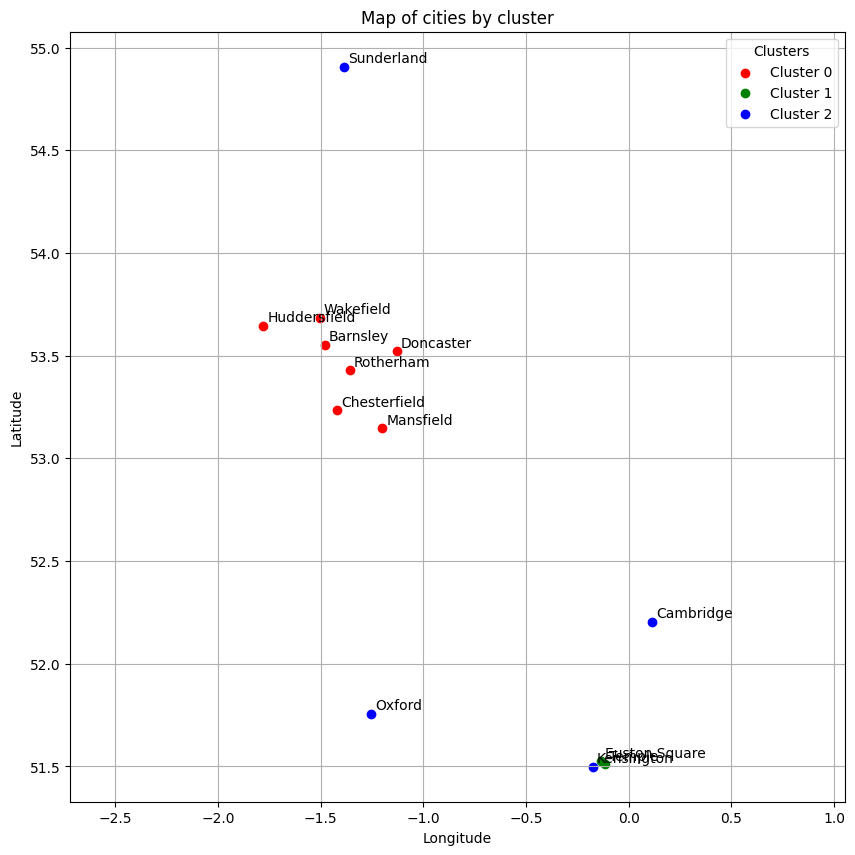

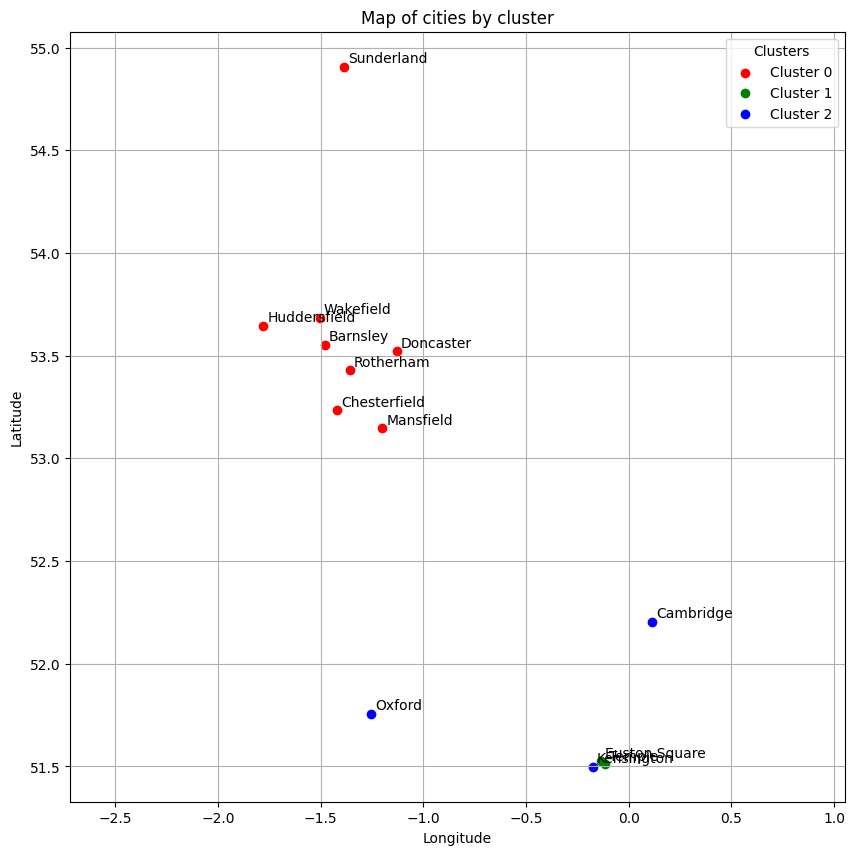

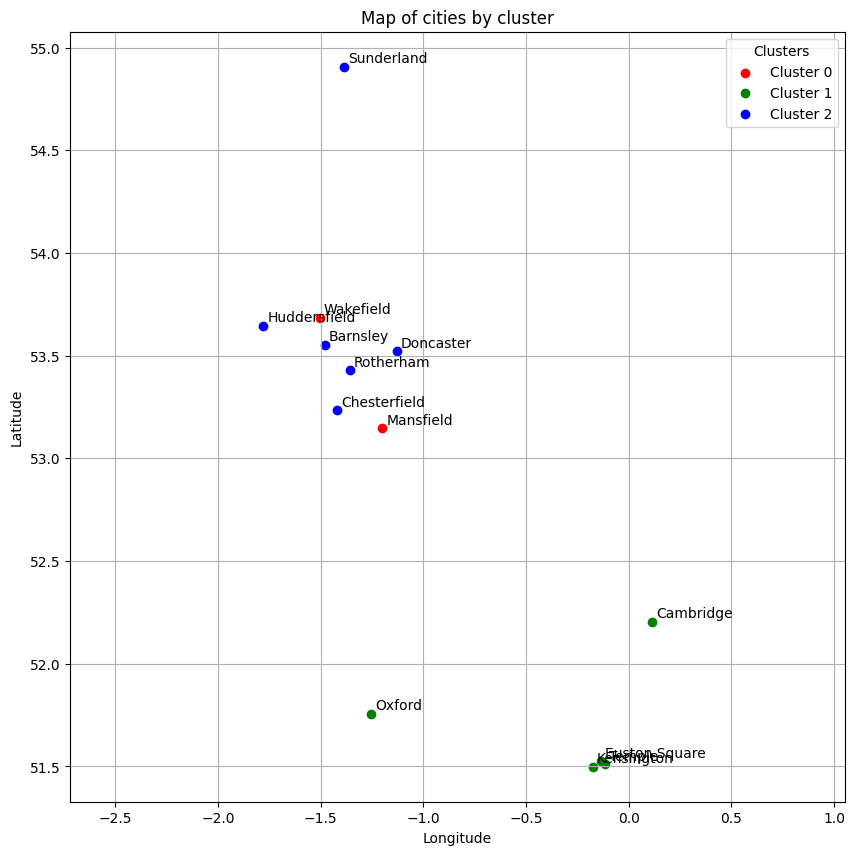

In [1126]:
plot_clusters(osm_feature_counts_df_clus)
plot_clusters(osm_feature_counts_df_clus_manu)
plot_clusters(osm_feature_counts_df_clus_norm)

### Exercise 4

Normalise your dataframe and compute a distance matrix for the
locations. Visualise it, and compare the outcode with your previous
clustering results.

### Exercise 4 Answer

#### Installs and imports

In [ ]:
%pip install numpy

In [543]:
import numpy as np

#### Initializing osm_feature_counts_df_coor

In [546]:
osm_feature_counts_df_coor = osm_feature_counts_df_clus.copy().drop(columns=['cluster'])

In [ ]:
osm_feature_counts_df_coor

#### Normalising DataFrame

In [1127]:
def normalise_df(data):

    locations = data['location']
    data = data.drop(columns=['location'])
    
    scaler = MinMaxScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

    locations_df = pd.DataFrame({"location": locations})
    normalised_df = pd.concat([locations_df, scaled_data], axis=1)

    return normalised_df

In [558]:
osm_feature_counts_df_norm = normalise_df(osm_feature_counts_df.copy())

In [1131]:
osm_feature_counts_df_norm

,location,amenity,historic,leisure,shop,sport,tourism,healthcare
0,Cambridge,0.472412,0.234234,0.810811,0.234450,1.000000,0.467456,0.081967
1,Oxford,0.483447,0.648649,1.000000,0.363636,0.863636,0.692308,0.147541
2,Euston Square,1.000000,0.972973,0.454955,1.000000,0.227273,0.994083,1.000000
3,Temple,0.863374,1.000000,0.346847,0.820574,0.136364,1.000000,0.377049
4,Kensington,0.438781,0.540541,0.441441,0.320574,0.318182,0.656805,0.360656
5,Barnsley,0.066737,0.027027,0.153153,0.337321,0.181818,0.053254,0.213115
6,Mansfield,0.068313,0.072072,0.139640,0.327751,0.681818,0.053254,0.229508
7,Wakefield,0.108776,0.009009,0.180180,0.500000,0.681818,0.047337,0.262295
8,Sunderland,0.282186,0.054054,0.085586,0.203349,0.090909,0.142012,0.147541
9,Rotherham,0.000000,0.000000,0.076577,0.000000,0.045455,0.000000,0.196721


#### Distance matrix for the locations

In [551]:
def distance(lat1, lon1, lat2, lon2):
    """
    Calculates distance between two points with given coordinates using 111 km approximation
    """
    return np.sqrt((lat1 - lat2) * 111 * (lat1 - lat2) * 111 + (lon1 - lon2) * 111 * (lon1 - lon2) * 111)

In [1128]:
def get_distance_matrix_df(osm_feature_counts_df_coor):
    
    # Create distance matrix filled with 0s
    dim = len(osm_feature_counts_df_coor)
    distance_matrix = np.zeros((dim, dim))

    # Calculate distance matrix
    for i in range(dim):
        for j in range(dim):
            distance_matrix[i, j] = distance(
                osm_feature_counts_df_coor.loc[i, 'latitude'], 
                osm_feature_counts_df_coor.loc[i, 'longitude'],
                osm_feature_counts_df_coor.loc[j, 'latitude'], 
                osm_feature_counts_df_coor.loc[j, 'longitude']
            )

    # Convert distance matrix to DataFrame
    distance_matrix_df = pd.DataFrame(distance_matrix,
                                    columns=osm_feature_counts_df_coor['location'],
                                    index=osm_feature_counts_df_coor['location'])
    
    return distance_matrix_df

In [1219]:
def plot_distance_matrix_df(distance_matrix_df, locations):

    dim = len(distance_matrix_df)

    plt.figure(figsize=(10, 8))
    plt.imshow(distance_matrix_df, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Distance in km')

    plt.title("Distance matrix")
    plt.xticks(np.arange(dim), locations, rotation=45, ha='right')
    plt.yticks(np.arange(dim), locations)
    plt.tight_layout()

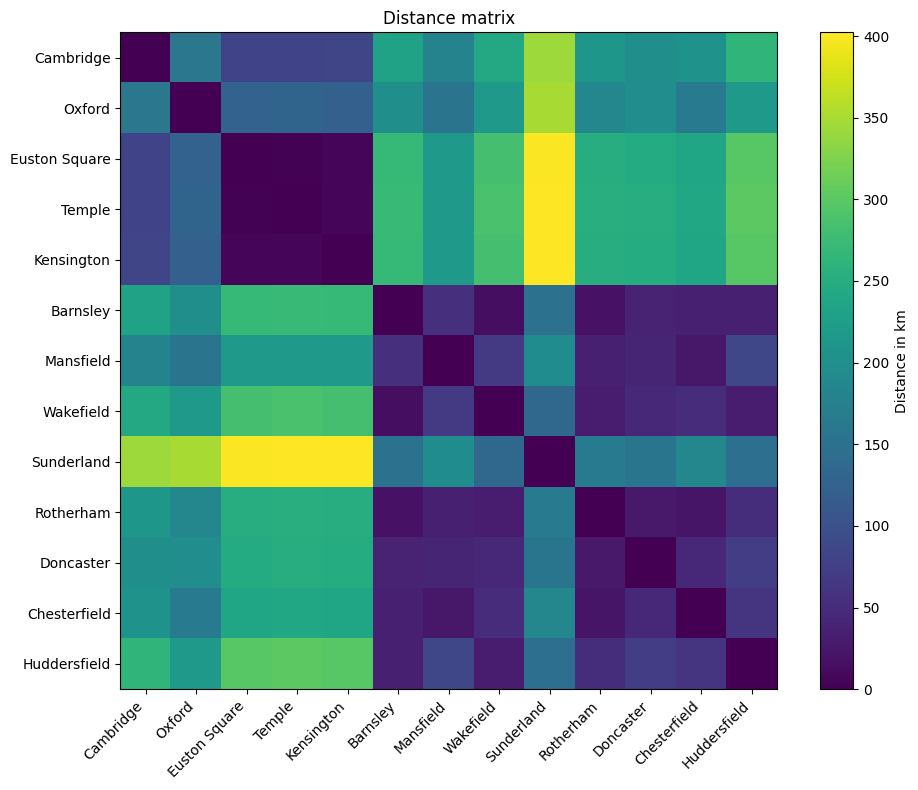

In [1220]:
distance_matrix_df = get_distance_matrix_df(osm_feature_counts_df_coor)
plot_distance_matrix_df(distance_matrix_df, osm_feature_counts_df_coor['location'])

### Exercise 5

Which features you included were correlated among each other?
Investigate and plot a feature correlation matrix. What do these results
say about your feature selection?

### Exercise 5 Answer

#### Correlation matrix

In [1132]:
def plot_correlation_matrix(correlation_matrix):

    dim = len(correlation_matrix.columns)

    plt.figure(figsize=(10, 8))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label='Correlation Coefficient')
    plt.title("Correlation Matrix of Features")
    plt.xticks(range(dim), correlation_matrix.columns, rotation=45, ha='right')
    plt.yticks(range(dim), correlation_matrix.columns)

    # Add correlation values to cells
    for i in range(dim):
        for j in range(dim):
            plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", ha="center", va="center", color="black")

    plt.tight_layout()

In [1133]:
correlation_matrix = osm_feature_counts_df_norm.copy().drop(columns=['location']).corr()

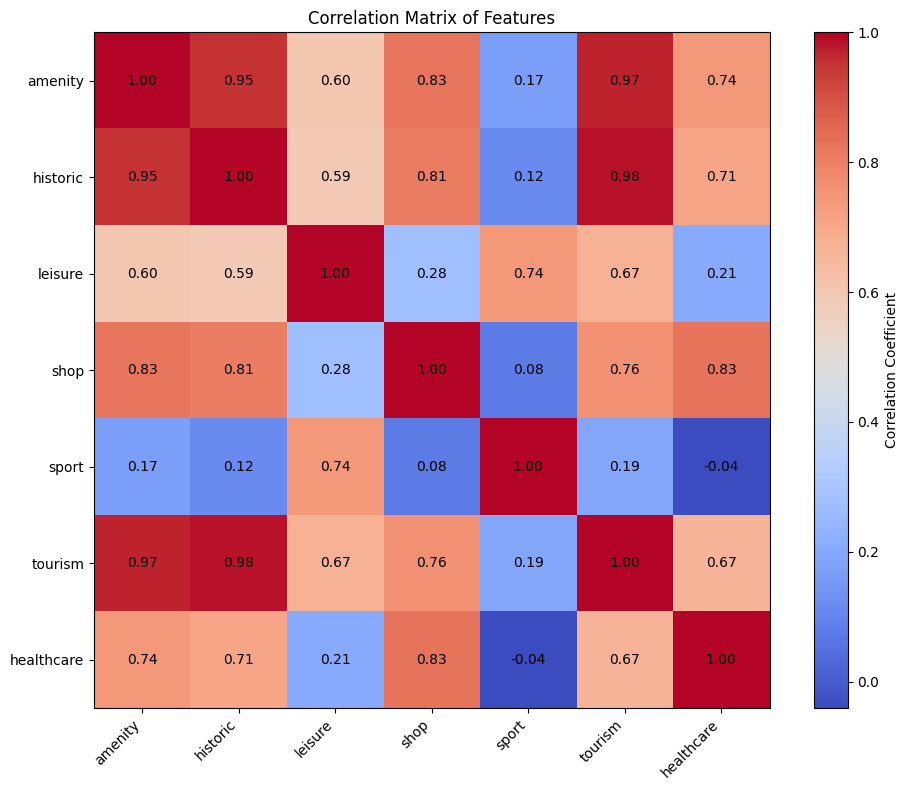

In [1134]:
plot_correlation_matrix(correlation_matrix)

As we can see, selected features are quite correlated with each other. This makes sense, as all numbers are typically positively affected by high population density and good economical state and negatively affected in the opposite case.

## Joining Spatial Data

<span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/snippets/edit/main/_access/includes/spatial-join.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/snippets/edit/main/_access/includes/spatial-join.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

### Matching OpenStreetMap and House Prices data

In this exercise you will download the geographies of houses from
OpenStreetMap and map them to visualise the records you see in the house
price dataset. This is a data linking and validation exercise.

The latitude and longitude of Cambridge are as follows:

In [1135]:
place_name = "Cambridge"
latitude = 52.1951
longitude = 0.1313

We want to execute an SQL query on your database to select all houses in
a 1km x 1km region around the centre of Cambridge that have been part of
housing transactions since 2020.

This operation can take a very long time. This is because the table is
not indexed on coordinate data, and therefore the query has to check
tens of millions of rows. This can be fixed by constructing an index on
the `latitude` and `longitude` values, using `BTREE` to make a joint
index. *Note that indexing can take a long time.* Consider also indexing
your table by other variables you might find useful later.

### Exercise 6

Index the table on the coordinate data using a `BTREE` and index other
columns you might find useful.

### Exercise 6 Answer

#### Installs and imports

In [1136]:
%pip install pyyaml
%pip install ipython-sql
%pip install PyMySQL
%pip install pymysql
%load_ext sql

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [1137]:
import yaml
import pymysql

In [1138]:
%pip uninstall --yes fynesse
%pip install git+https://github.com/sdenyskov/sd995_ads_2024.git

Found existing installation: fynesse 0.1.0
Uninstalling fynesse-0.1.0:
  Successfully uninstalled fynesse-0.1.0
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/sdenyskov/sd995_ads_2024.git to /private/var/folders/tq/f7lcjhp564g26624rbp38l240000gn/T/pip-req-build-6l60arp6
  Running command git clone --filter=blob:none --quiet https://github.com/sdenyskov/sd995_ads_2024.git /private/var/folders/tq/f7lcjhp564g26624rbp38l240000gn/T/pip-req-build-6l60arp6
  Resolved https://github.com/sdenyskov/sd995_ads_2024.git to commit f1c158e4d69722719072d46a48e9edbec0c1aa7c
  Preparing metadata (setup.py) ... done
  Created wheel for fynesse: filename=fynesse-0.1.0-py3-none-any.whl size=7060 sha256=ccb407c1c43cc2da21103c3fe578998394642d47fa207bf56b494eda241fe66b
  Stored in directory: /private/var/folders/tq/f7lcjhp564g26624rbp38l240000gn/T/pip-ephem-wheel-cache-_yn9m_bh/wheels/3c/89/03/7b7d5f4887f9d2568c1996e5bc272e3e23ab7406662c635b84
Successfully built

In [1139]:
import fynesse

#### Connection and cursor initiation

In [1228]:
with open("credentials.yaml") as file:
  credentials = yaml.safe_load(file)
username = credentials["username"]
password = credentials["password"]
url = credentials["url"]
port = credentials["port"]

In [1229]:
conn = fynesse.access.create_connection(user=username, password=password, host=url, database='ads_2024')
cursor = conn.cursor()

Connection established!


#### Indexing tables

In [ ]:
cursor.execute("CREATE INDEX idx_lat_lon_btree ON `prices_coordinates_data` (latitude, longitude)")
conn.commit()

#### Checking properties of tables

In [1142]:
cursor.execute("SHOW INDEXES FROM `prices_coordinates_data`")
results = cursor.fetchall()
for result in results:
    print(result)

('prices_coordinates_data', 0, 'PRIMARY', 1, 'db_id', 'A', 5038203, None, None, '', 'BTREE', '', '', 'NO')
('prices_coordinates_data', 1, 'idx_lat_lon_btree', 1, 'latitude', 'A', 2519101, None, None, '', 'BTREE', '', '', 'NO')
('prices_coordinates_data', 1, 'idx_lat_lon_btree', 2, 'longitude', 'A', 2519101, None, None, '', 'BTREE', '', '', 'NO')


In [1143]:
cursor.execute("SELECT MIN(date_of_transfer) AS min_value, MAX(date_of_transfer) AS max_value FROM `prices_coordinates_data`")
results = cursor.fetchall()
print(results)

((datetime.date(2020, 1, 1), datetime.date(2024, 9, 30)),)


In [1144]:
cursor.execute("SELECT column_name FROM information_schema.columns WHERE table_name = 'prices_coordinates_data'")
results = cursor.fetchall()
for result in results:
    print(result[0])

price
date_of_transfer
postcode
property_type
new_build_flag
tenure_type
locality
town_city
district
county
country
latitude
longitude
db_id


In [1145]:
cursor.execute("SELECT * FROM `prices_coordinates_data` LIMIT 5")
results = cursor.fetchall()
for result in results:
    print(result)

(370000, datetime.date(2024, 1, 1), 'WR12 7FE', 'T', 'N', 'F', '', 'BROADWAY', 'WYCHAVON', 'WORCESTERSHIRE', 'England', Decimal('52.04243800'), Decimal('-1.85757200'), 1)
(50000, datetime.date(2024, 1, 1), 'TS17 6LJ', 'T', 'N', 'F', 'THORNABY', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'England', Decimal('54.55240100'), Decimal('-1.30114300'), 2)
(485000, datetime.date(2024, 1, 1), 'BR3 6QH', 'F', 'N', 'L', '', 'BECKENHAM', 'BROMLEY', 'GREATER LONDON', 'England', Decimal('51.40061400'), Decimal('-0.01854100'), 3)
(226000, datetime.date(2024, 1, 1), 'BL9 9EZ', 'S', 'N', 'F', '', 'BURY', 'BURY', 'GREATER MANCHESTER', 'England', Decimal('53.58415200'), Decimal('-2.28348100'), 4)
(64000, datetime.date(2024, 1, 1), 'NE29 7LT', 'F', 'N', 'L', '', 'NORTH SHIELDS', 'NORTH TYNESIDE', 'TYNE AND WEAR', 'England', Decimal('55.01156300'), Decimal('-1.46931900'), 5)


### Exercise 7

Write an SQL query on your database to select all houses in a 1km x 1km
region around the centre of Cambridge that have been part of housing
transactions since 2020.

### Exercise 7 Answer

#### Calculating bounds of the area

In [1146]:
def get_bounds(latitude, longitude, box_dim_km):

    box_dim = box_dim_km / 111
    north = latitude + box_dim / 2
    south = latitude - box_dim / 2
    east = longitude + box_dim / 2
    west = longitude - box_dim / 2

    return (north, south, east, west)

In [1147]:
bounds = get_bounds(latitude, longitude, 1)
north, south, east, west = bounds

#### Forming all_houses_from_db

In [1217]:
def get_houses_in_the_area(cursor, bounds):

    north, south, east, west = bounds
    columns = ["price", 
               "date_of_transfer", 
               "postcode", 
               "property_type", 
               "new_build_flag", 
               "tenure_type", 
               "locality", 
               "town_city", 
               "district", 
               "county", 
               "country", 
               "latitude", 
               "longitude", 
               "db_id", 
               "primary_addressable_object_name", 
               "secondary_addressable_object_name", 
               "street"]

    # cursor.execute(f"SELECT * FROM `prices_coordinates_data` WHERE latitude BETWEEN {south} AND {north} AND longitude BETWEEN {west} AND {east} AND date_of_transfer >= '2020-01-01'")
    cursor.execute(f"SELECT pcd.*, pp.primary_addressable_object_name, pp.secondary_addressable_object_name, pp.street FROM prices_coordinates_data AS pcd JOIN pp_data AS pp ON pcd.postcode = pp.postcode AND pcd.date_of_transfer = pp.date_of_transfer AND pcd.price = pp.price WHERE pcd.latitude BETWEEN {south} AND {north} AND pcd.longitude BETWEEN {west} AND {east} AND pcd.date_of_transfer >= '2020-01-01'")
    results = cursor.fetchall()

    df = pd.DataFrame(results, columns = columns)

    return df

In [1149]:
all_houses_from_db = get_houses_in_the_area(cursor, bounds)
print(len(all_houses_from_db))

all_houses_from_db = all_houses_from_db.drop_duplicates(subset=all_houses_from_db.columns.difference(['db_id']))
print(len(all_houses_from_db))

312
230


In [1150]:
all_houses_from_db

,price,date_of_transfer,postcode,property_type,new_build_flag,tenure_type,locality,town_city,district,county,country,latitude,longitude,db_id,primary_addressable_object_name,secondary_addressable_object_name,street
0,392000,2023-06-19,CB2 8DB,F,N,L,,CAMBRIDGE,CAMBRIDGE,CAMBRIDGESHIRE,England,52.19064200,0.13335700,739211,11,,GLENALMOND AVENUE
1,500000,2023-07-13,CB2 8DB,F,N,L,,CAMBRIDGE,CAMBRIDGE,CAMBRIDGESHIRE,England,52.19064200,0.13335700,796927,32,,GLENALMOND AVENUE
4,13900000,2020-07-16,CB2 8FH,O,N,F,,CAMBRIDGE,CAMBRIDGE,CAMBRIDGESHIRE,England,52.19087700,0.13279700,2734841,CLARENDON HOUSE,,CLARENDON ROAD
5,1430000,2021-05-28,CB2 8DW,T,N,F,,CAMBRIDGE,CAMBRIDGE,CAMBRIDGESHIRE,England,52.19094400,0.12760600,3800185,2,,RICHARD FOSTER ROAD
6,1500000,2021-03-05,CB2 8DP,T,N,F,,CAMBRIDGE,CAMBRIDGE,CAMBRIDGESHIRE,England,52.19097200,0.12801700,3488542,4,,ABERDEEN AVENUE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,475000,2021-06-29,CB1 2HW,T,N,F,,CAMBRIDGE,CAMBRIDGE,CAMBRIDGESHIRE,England,52.19957500,0.13460400,3961662,10,,CROSS STREET
306,528000,2022-08-31,CB1 2HW,T,N,F,,CAMBRIDGE,CAMBRIDGE,CAMBRIDGESHIRE,England,52.19957500,0.13460400,5266483,22,,CROSS STREET
307,570000,2024-05-31,CB1 2EH,F,N,L,,CAMBRIDGE,CAMBRIDGE,CAMBRIDGESHIRE,England,52.19959600,0.13049300,240275,23,,FENNERS LAWN
308,555000,2023-01-05,CB1 2EH,F,N,L,,CAMBRIDGE,CAMBRIDGE,CAMBRIDGESHIRE,England,52.19959600,0.13049300,397192,26,,FENNERS LAWN


### Exercise 8

Get information about all the buildings in that area from OpenStreetMaps
(`'building': True`). You will need their address information
(`addr:housenumber`, `addr:street`, `addr:postcode`, …) and geometry
polygon (`geometries_from_bbox`). Construct a dataframe that lists all
OSM buildings in the area that have a full address, along with their
area (in square meters). Plot a map of the area, using color to mark the
buildings with addresses and the ones without.

### Exercise 8 Answer

#### Installs and imports

In [1222]:
%pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [1223]:
import geopandas as gpd

#### Forming all_buildings_from_osm

In [1157]:
def get_all_buildings_from_osm(bounds):

    north, south, east, west = bounds

    # Get information about all buildings in the area
    all_buildings_from_osm = ox.geometries_from_bbox(north, south, east, west, tags = {'building': True})

    # Filter polygons only
    all_buildings_from_osm = all_buildings_from_osm[all_buildings_from_osm['geometry'].geom_type == 'Polygon']

    # From geographical coordinate reference system to projected reference system, then compute area in square meters
    all_buildings_from_osm['area_m2'] = all_buildings_from_osm.copy().to_crs(epsg=3395).geometry.area

    return all_buildings_from_osm

In [1158]:
all_buildings_from_osm = get_all_buildings_from_osm(bounds)
print(len(all_buildings_from_osm))
all_buildings_from_osm

534


/var/folders/tq/f7lcjhp564g26624rbp38l240000gn/T/ipykernel_8790/825762988.py:6: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  all_buildings_from_osm = ox.geometries_from_bbox(north, south, east, west, tags = {'building': True})
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/osmnx/geometries.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return features.features_from_bbox(north, south, east, west, tags=tags)
/Library/Frameworks/Python.framework/Versions/3.10/lib/

amenity  \
element_type osmid                          
way          28629451         arts_centre   
             33167535    place_of_worship   
             34699974                 NaN   
             39185783                 NaN   
             40964578    place_of_worship   
...                                   ...   
             1271723407               NaN   
relation     1860558                  NaN   
             1913621                  NaN   
             3540620                  NaN   
             7544766                  NaN   

                                                                  geometry  \
element_type osmid                                                           
way          28629451    POLYGON ((0.13678 52.19061, 0.13613 52.19062, ...   
             33167535    POLYGON ((0.12765 52.19857, 0.12763 52.19855, ...   
             34699974    POLYGON ((0.12892 52.19425, 0.12920 52.19428, ...   
             39185783    POLYGON ((0.13182 52.19912, 0.13216 52.19942, ...   
             40964578    POLYGON ((0.12932 52.19748, 0.12930 52.19750, ...   
...                                                                    ...   
             1271723407  POLYGON ((0.13069 52.19096, 0.13071 52.19090, ...   
relation     1860558     POLYGON ((0.13336 52.19175, 0.13332 52.19188, ...   
             1913621     POLYGON ((0.12686 52.19458, 0.12686 52.19457, ...   
             3540620     POLYGON ((0.12883 52.19664, 0.12880 52.19664, ...   
             7544766     POLYGON ((0.13336 52.19175, 0.13332 52.19188, ...   

                         addr:city addr:full addr:housenumber  \
element_type osmid                                              
way          28629451    Cambridge       NaN                1   
             33167535    Cambridge       NaN              NaN   
             34699974    Cambridge       NaN              NaN   
             39185783          NaN       NaN              NaN   
             40964578    Cambridge       NaN              NaN   
...                            ...       ...              ...   
             1271723407        NaN       NaN              NaN   
relation     1860558     Cambridge       NaN          126-130   
             1913621     Cambridge       NaN              NaN   
             3540620     Cambridge       NaN                4   
             7544766     Cambridge       NaN              NaN   

                        addr:interpolation addr:postcode       addr:street  \
element_type osmid                                                           
way          28629451                  NaN       CB1 7GX       Clifton Way   
             33167535                  NaN       CB2 1JR        Hills Road   
             34699974                  NaN           NaN               NaN   
             39185783                  NaN           NaN               NaN   
             40964578                  NaN       CB2 1JP        Hills Road   
...                                    ...           ...               ...   
             1271723407                NaN       CB2 8BW  Shaftesbury Road   
relation     1860558                   NaN       CB2 1RE        Hills Road   
             1913621                   NaN           NaN               NaN   
             3540620                   NaN       CB2 1HT    Russell Street   
             7544766                   NaN           NaN               NaN   

                        source  \
element_type osmid               
way          28629451     bing   
             33167535    Yahoo   
             34699974      NaN   
             39185783      NaN   
             40964578      NaN   
...                        ...   
             1271723407    NaN   
relation     1860558       NaN   
             1913621       NaN   
             3540620       NaN   
             7544766      Bing   

                                                                      name  \
element_type osmid                                 

#### Forming valid_buildings_from_osm

In [1159]:
def filter_buildings_from_osm(all_buildings_from_osm):
    
    # Filter buildings based on the presence of address
    valid_buildings_from_osm = all_buildings_from_osm[all_buildings_from_osm['addr:street'].notnull() 
                                                    & all_buildings_from_osm['addr:housenumber'].notnull() 
                                                    & all_buildings_from_osm['addr:postcode'].notnull()
                                                    & all_buildings_from_osm['addr:city'].notnull()]
    
    return valid_buildings_from_osm

In [1160]:
valid_buildings_from_osm = filter_buildings_from_osm(all_buildings_from_osm.copy())
print(len(valid_buildings_from_osm))
valid_buildings_from_osm

282


amenity  \
element_type osmid                    
way          28629451   arts_centre   
             45675956           NaN   
             45675961           NaN   
             45675965           NaN   
             45826776           NaN   
...                             ...   
             972902642          NaN   
             972902643          NaN   
             972902644          NaN   
relation     1860558            NaN   
             3540620            NaN   

                                                                 geometry  \
element_type osmid                                                          
way          28629451   POLYGON ((0.13678 52.19061, 0.13613 52.19062, ...   
             45675956   POLYGON ((0.13290 52.19473, 0.13310 52.19470, ...   
             45675961   POLYGON ((0.13378 52.19456, 0.13420 52.19450, ...   
             45675965   POLYGON ((0.13186 52.19491, 0.13180 52.19478, ...   
             45826776   POLYGON ((0.12904 52.19777, 0.12967 52.19799, ...   
...                                                                   ...   
             972902642  POLYGON ((0.12689 52.19905, 0.12685 52.19906, ...   
             972902643  POLYGON ((0.12683 52.19895, 0.12680 52.19896, ...   
             972902644  POLYGON ((0.12703 52.19913, 0.12701 52.19911, ...   
relation     1860558    POLYGON ((0.13336 52.19175, 0.13332 52.19188, ...   
             3540620    POLYGON ((0.12883 52.19664, 0.12880 52.19664, ...   

                        addr:city addr:full addr:housenumber  \
element_type osmid                                             
way          28629451   Cambridge       NaN                1   
             45675956   Cambridge       NaN               10   
             45675961   Cambridge       NaN               22   
             45675965   Cambridge       NaN                1   
             45826776   Cambridge       NaN            13-15   
...                           ...       ...              ...   
             972902642  Cambridge       NaN               14   
             972902643  Cambridge       NaN            16-18   
             972902644  Cambridge       NaN               10   
relation     1860558    Cambridge       NaN          126-130   
             3540620    Cambridge       NaN                4   

                       addr:interpolation addr:postcode     addr:street  \
element_type osmid                                                        
way          28629451                 NaN       CB1 7GX     Clifton Way   
             45675956                 NaN       CB1 2JD    Station Road   
             45675961                 NaN       CB1 2JD    Station Road   
             45675965                 NaN       CB1 2JY    Station Road   
             45826776                 NaN       CB2 1NL      Hills Road   
...                                   ...           ...             ...   
             972902642                NaN       CB2 1EG  Lensfield Road   
             972902643                NaN       CB2 1EG  Lensfield Road   
             972902644                NaN       CB2 1EG  Lensfield Road   
relation     1860558                  NaN       CB2 1RE      Hills Road   
             3540620                  NaN       CB2 1HT  Russell Street   

                       source                                       name  ...  \
element_type osmid                                                        ...   
way          28629451    bing                         Cambridge Junction  ...   
             45675956   yahoo                              Jupiter House  ...   
             45675961   yahoo                    Twenty-Two Station Road  ...   
             45675965     NaN                                 Kett House  ...   
             45826776   yahoo                           Terrington House  ...   
...                       ...                                        ...  ...   
             972902642    NaN                                

#### Plotting the area

In [1161]:
def plot_buildings(bounds, layer1, layer2 = None, layer3 = None):

    north, south, east, west = bounds
    
    # Retrieve main graph
    graph = ox.graph_from_bbox(north, south, east, west)

    # Retrieve nodes and edges
    nodes, edges = ox.graph_to_gdfs(graph)

    # Get place boundary related to the place name as a geodataframe
    area = ox.geocode_to_gdf(place_name)

    # Initialise plot
    fig, ax = plt.subplots()

    # Plot the footprint
    area.plot(ax=ax, facecolor="white")

    # Plot street edges
    edges.plot(ax=ax, linewidth=1, edgecolor="dimgray")

    ax.set_xlim([west, east])
    ax.set_ylim([south, north])
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")

    # Plot buildings
    layer1.plot(ax=ax, color="grey", alpha=0.7, markersize=10)
    if layer2 is not None:
        layer2.plot(ax=ax, color="blue", alpha=0.7, markersize=10)
    if layer3 is not None:
        layer3.plot(ax=ax, color="red", alpha=0.7, markersize=10)
    
    plt.tight_layout()

/var/folders/tq/f7lcjhp564g26624rbp38l240000gn/T/ipykernel_8790/3737116293.py:6: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  graph = ox.graph_from_bbox(north, south, east, west)
/var/folders/tq/f7lcjhp564g26624rbp38l240000gn/T/ipykernel_8790/3737116293.py:6: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  graph = ox.graph_from_bbox(north, south, east, west)


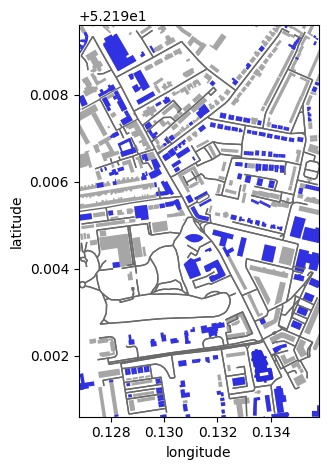

In [1218]:
plot_buildings(bounds, all_buildings_from_osm, valid_buildings_from_osm)

### Exercise 9

Match the houses you found in the price paid dataset with the buildings
on OpenStreetMaps based on their addresses. Can this be applied to all
building types? Are there any PP transactions which you couldn’t match
to an OSM building, or any OSM buildings you coulnd’t match to a PP
transaction? If so, what could be the reason for this? Do you employ any
techniques to find non-exact matches? If yes, what matches would you
have missed without it? Are you encountering false positive matches? Use
this address matching to merge the two dataframes.

### Exercise 9 Answer

This can be applied to other building types (for example, bars, etc.) as well.

Yes, there are unmatchable records on each of two sides. This is due to some information missing, and due to the differences in format of object namess and numbers.

Yes, I do use certain techniques to find non-exact matches. The basic one is to ignore lower/upper case in strings. Another one is to avoid doing equality checks on building names if they are not integers. In such a case it's better to check if one of the names is a substring of another one.

False positives are also possible, for example when we match Bens Barbershop against Rubens Barbershop - as 'Bens Barbershop' is a substring of 'Rubens Barbershop', current algorithms is likely to see a match where it shouldn't happen.

#### Exploring existing datasets

In [1177]:
all_houses_from_db[['price', 
                    'date_of_transfer', 
                    'postcode', 
                    'town_city', 
                    'latitude', 
                    'longitude', 
                    'primary_addressable_object_name', 
                    'secondary_addressable_object_name', 
                    'street', 
                    'db_id']][all_houses_from_db['street'] == 'STATION ROAD']

,price,date_of_transfer,postcode,town_city,latitude,longitude,primary_addressable_object_name,secondary_addressable_object_name,street,db_id
89,20840000,2020-11-13,CB1 2JD,CAMBRIDGE,52.19443900,0.13397600,20,,STATION ROAD,3068129
90,15215000,2021-08-09,CB1 2RP,CAMBRIDGE,52.19465700,0.13308100,JUPITER HOUSE,,STATION ROAD,4081819
91,20100000,2023-02-21,CB1 2FB,CAMBRIDGE,52.19472600,0.13552600,"THE TAMBURLAINE, 27 - 29",,STATION ROAD,496811
100,32000,2021-02-17,CB1 2JB,CAMBRIDGE,52.19518800,0.13155500,11,,STATION ROAD,3415173


In [1178]:
valid_buildings_from_osm[['geometry', 
                          'addr:city', 
                          'addr:housenumber', 
                          'addr:postcode', 
                          'addr:street', 
                          'name', 
                          'area_m2']][valid_buildings_from_osm['addr:street'] == 'Station Road']

geometry  \
element_type osmid                                                          
way          45675956   POLYGON ((0.13290 52.19473, 0.13310 52.19470, ...   
             45675961   POLYGON ((0.13378 52.19456, 0.13420 52.19450, ...   
             45675965   POLYGON ((0.13186 52.19491, 0.13180 52.19478, ...   
             52158647   POLYGON ((0.13597 52.19491, 0.13584 52.19458, ...   
             134808009  POLYGON ((0.13161 52.19520, 0.13144 52.19522, ...   
             134808012  POLYGON ((0.13157 52.19511, 0.13165 52.19509, ...   
             134809482  POLYGON ((0.13248 52.19514, 0.13252 52.19525, ...   
             204018375  POLYGON ((0.13510 52.19469, 0.13471 52.19475, ...   
             407494963  POLYGON ((0.13129 52.19526, 0.13133 52.19524, ...   
             731796259  POLYGON ((0.13489 52.19397, 0.13492 52.19404, ...   

                        addr:city addr:housenumber addr:postcode  \
element_type osmid                                                 
way          45675956   Cambridge               10       CB1 2JD   
             45675961   Cambridge               22       CB1 2JD   
             45675965   Cambridge                1       CB1 2JY   
             52158647   Cambridge            27-29       CB1 2FB   
             134808009  Cambridge              1-3       CB1 2JB   
             134808012  Cambridge                7       CB1 2JB   
             134809482  Cambridge               17       CB1 2JB   
             204018375  Cambridge               21       CB1 2FB   
             407494963  Cambridge                1       CB1 2JB   
             731796259  Cambridge            50-60       CB1 2JH   

                         addr:street                     name      area_m2  
element_type osmid                                                          
way          45675956   Station Road            Jupiter House  1797.304645  
             45675961   Station Road  Twenty-Two Station Road  3279.323133  
             45675965   Station Road               Kett House  2866.498567  
             52158647   Station Road  Clayton Hotel Cambridge  4344.011187  
             134808009  Station Road               Smokeworks   599.949238  
             134808012  Station Road    Norfolk Street Bakery   164.678302  
             134809482  Station Road            Abbey College   478.867654  
             204018375  Station Road       Microsoft Research  3920.104234  
             407494963  Station Road               The Q Club   146.639566  
             731796259  Station Road       50/60 Station Road  6829.171744

#### Constructing matched_buildings_from_osm

In [1182]:
def capitalize(x):
    return x.upper() if isinstance(x, str) else str(x)

In [1183]:
def match_buildings_from_osm(valid_buildings_from_osm, all_houses_from_db):

    # Create a copy of valid_buildings_from_osm
    matched_buildings_from_osm = valid_buildings_from_osm.copy()

    # Create empty lists to store matched data
    matched_price = []
    matched_date_of_transfer = []
    matched_latitude = []
    matched_longitude = []

    # Iterate through the rows of matched_buildings_from_osm
    for _, osm_row in matched_buildings_from_osm.iterrows():
        name = capitalize(osm_row['name'])
        housenumber = capitalize(osm_row['addr:housenumber'])
        street = capitalize(osm_row['addr:street'])
        city = capitalize(osm_row['addr:city'])
        postcode = capitalize(osm_row['addr:postcode'])

        # Iterate through the rows of all_houses_from_db
        match_found = False
        for _, db_row in all_houses_from_db.iterrows():
            primary_addressable_object_name = capitalize(db_row['primary_addressable_object_name'])
            secondary_addressable_object_name = capitalize(db_row['secondary_addressable_object_name'])
            db_street = capitalize(db_row['street'])
            db_city = capitalize(db_row['town_city'])
            db_postcode = capitalize(db_row['postcode'])
            
            # Check if street, postcode, and city match
            if street == db_street and postcode == db_postcode and city == db_city:
                if (housenumber == primary_addressable_object_name) or (housenumber == secondary_addressable_object_name) or (name in primary_addressable_object_name) or (name in secondary_addressable_object_name):
                    matched_price.append(db_row['price'])
                    matched_date_of_transfer.append(db_row['date_of_transfer'])
                    matched_latitude.append(db_row['latitude'])
                    matched_longitude.append(db_row['longitude'])
                    match_found = True
                    break

        # If no match was found, append None to the lists
        if not match_found:
            matched_price.append(None)
            matched_date_of_transfer.append(None)
            matched_latitude.append(None)
            matched_longitude.append(None)

    # Add the matched data as new columns in matched_buildings_from_osm
    matched_buildings_from_osm['price'] = matched_price
    matched_buildings_from_osm['date_of_transfer'] = matched_date_of_transfer
    matched_buildings_from_osm['latitude'] = matched_latitude
    matched_buildings_from_osm['longitude'] = matched_longitude

    # Remove rows where no match was found
    matched_buildings_from_osm.dropna(subset=['price', 'date_of_transfer', 'latitude', 'longitude'], inplace=True)

    return matched_buildings_from_osm

In [1184]:
matched_buildings_from_osm = match_buildings_from_osm(valid_buildings_from_osm, all_houses_from_db)

In [1185]:
matched_buildings_from_osm[['addr:city', 
                            'addr:housenumber', 
                            'addr:postcode', 
                            'addr:street', 
                            'name', 
                            'area_m2',
                            'price', 
                            'date_of_transfer', 
                            'latitude', 
                            'longitude']]

addr:city addr:housenumber addr:postcode  \
element_type osmid                                                 
way          134692264  Cambridge                8       CB1 2DY   
             134692266  Cambridge               14       CB1 2DY   
             134700792  Cambridge              16a       CB1 2HL   
             134700794  Cambridge               14       CB1 2HL   
             134806809  Cambridge               37       CB2 1NT   
             134811791  Cambridge                3       CB1 2HA   
             134834417  Cambridge               52       CB1 2HY   
             134834426  Cambridge               46       CB1 2EA   
             134834430  Cambridge               50       CB1 2EA   
             147861293  Cambridge              104       CB2 1LQ   
             151074171  Cambridge              21a       CB2 1HE   
             151081936  Cambridge              106       CB2 1LQ   
             161784729  Cambridge                6       CB2 8DE   
             161784738  Cambridge                2       CB2 8DE   
             161784741  Cambridge                7       CB2 8DE   
             161815602  Cambridge               16       CB2 8DX   
             169704335  Cambridge               10       CB2 1JT   
             430553226  Cambridge               15       CB1 2DX   
             430553307  Cambridge               28       CB1 2DY   
             486180369  Cambridge                7       CB1 2FZ   

                            addr:street            name      area_m2  \
element_type osmid                                                     
way          134692264   Tenison Avenue             NaN   142.630662   
             134692266   Tenison Avenue             NaN   176.064050   
             134700792   Lyndewode Road             NaN   199.444490   
             134700794   Lyndewode Road             NaN   208.593917   
             134806809       Hills Road             NaN  1263.091738   
             134811791     Glisson Road   Abbey College   329.909832   
             134834417      Mawson Road        Cambashi   384.102514   
             134834426      Mawson Road             NaN   134.415020   
             134834430      Mawson Road             NaN   124.496020   
             147861293       Hills Road  Betjeman House  4063.499873   
             151074171       Union Road             NaN   867.637819   
             151081936       Hills Road  The Flying Pig   302.088344   
             161784729  Morland Terrace             NaN   289.356017   
             161784738  Morland Terrace             NaN   271.584713   
             161784741  Morland Terrace             NaN   275.057264   
             161815602     Gilmour Road             NaN   207.979107   
             169704335       Hills Road             NaN   208.795412   
             430553226   Tenison Avenue             NaN   312.606607   
             430553307   Tenison Avenue             NaN   129.446296   
             486180369  Eccleston Place             NaN   417.034334   

                             price date_of_transfer     latitude   longitude  
element_type osmid                                                            
way          134692264   1400000.0       2022-05-25  52.19660700  0.13367100  
             134692266   1758000.0       2021-06-29  52.19660700  0.13367100  
             134700792   2550000.0       2021-06-29  52.19744500  0.13257000  
             134700794   1900000.0       2024-08-27  52.19744500  0.13257000  
             134806809   7500000.0       2021-11-24  52.19527500  0.13123700  
             134811791    900000.0       2023-11-03  52.19741500  0.13123700  
             134834417    655000.0       2022-01-11  52.19906900  0.13475500  
             134834426    740000.0       2022-06-30  52.19896900  0.13480900  
             134834430    450000.0       2022-01-28  52.19896900  0.13480900  
             147861293  10000000.0       2020-06-24  52.19527200  0.13066

#### Plotting

/var/folders/tq/f7lcjhp564g26624rbp38l240000gn/T/ipykernel_8790/3737116293.py:6: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  graph = ox.graph_from_bbox(north, south, east, west)
/var/folders/tq/f7lcjhp564g26624rbp38l240000gn/T/ipykernel_8790/3737116293.py:6: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  graph = ox.graph_from_bbox(north, south, east, west)


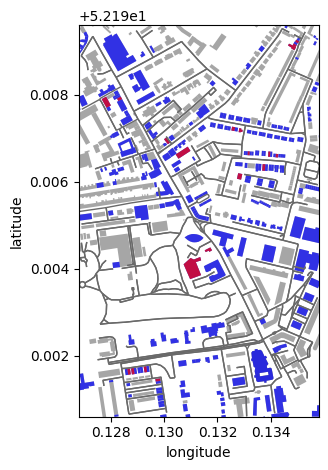

In [1187]:
plot_buildings(bounds, all_buildings_from_osm, valid_buildings_from_osm, matched_buildings_from_osm)

### Exercise 10

Examine the relationship between the price and area of a property. -
What other variables do you need to account for? - Is the correlation as
strong as you would expect? - What factors could be impacting this?

Visualise the relationships you found.

### Exercise 10 Answer

As can be seen from the current sample of data, factors that can affect price of the property are, obviously, area of property, type of property, location of property and date of transfer (inflation!).

The highest correlation will obviously be expected between price and area of property. 

Measuring correlation between price and type of property or date of transfer is expected to be hard.

This analysis is obvoiusly impacted by relatively small size of sample that is being considered.

#### Exploring exisiting datasets

In [1199]:
df = matched_buildings_from_osm.copy().sort_values(by='date_of_transfer')

In [1200]:
df[['addr:city', 
    'addr:housenumber', 
    'addr:postcode', 
    'addr:street', 
    'name', 
    'area_m2',
    'price', 
    'date_of_transfer', 
    'latitude', 
    'longitude']]

addr:city addr:housenumber addr:postcode  \
element_type osmid                                                 
way          147861293  Cambridge              104       CB2 1LQ   
             151081936  Cambridge              106       CB2 1LQ   
             161784741  Cambridge                7       CB2 8DE   
             486180369  Cambridge                7       CB1 2FZ   
             169704335  Cambridge               10       CB2 1JT   
             430553226  Cambridge               15       CB1 2DX   
             161784729  Cambridge                6       CB2 8DE   
             161815602  Cambridge               16       CB2 8DX   
             134700792  Cambridge              16a       CB1 2HL   
             134692266  Cambridge               14       CB1 2DY   
             134806809  Cambridge               37       CB2 1NT   
             134834417  Cambridge               52       CB1 2HY   
             134834430  Cambridge               50       CB1 2EA   
             161784738  Cambridge                2       CB2 8DE   
             430553307  Cambridge               28       CB1 2DY   
             134692264  Cambridge                8       CB1 2DY   
             134834426  Cambridge               46       CB1 2EA   
             134811791  Cambridge                3       CB1 2HA   
             151074171  Cambridge              21a       CB2 1HE   
             134700794  Cambridge               14       CB1 2HL   

                            addr:street            name      area_m2  \
element_type osmid                                                     
way          147861293       Hills Road  Betjeman House  4063.499873   
             151081936       Hills Road  The Flying Pig   302.088344   
             161784741  Morland Terrace             NaN   275.057264   
             486180369  Eccleston Place             NaN   417.034334   
             169704335       Hills Road             NaN   208.795412   
             430553226   Tenison Avenue             NaN   312.606607   
             161784729  Morland Terrace             NaN   289.356017   
             161815602     Gilmour Road             NaN   207.979107   
             134700792   Lyndewode Road             NaN   199.444490   
             134692266   Tenison Avenue             NaN   176.064050   
             134806809       Hills Road             NaN  1263.091738   
             134834417      Mawson Road        Cambashi   384.102514   
             134834430      Mawson Road             NaN   124.496020   
             161784738  Morland Terrace             NaN   271.584713   
             430553307   Tenison Avenue             NaN   129.446296   
             134692264   Tenison Avenue             NaN   142.630662   
             134834426      Mawson Road             NaN   134.415020   
             134811791     Glisson Road   Abbey College   329.909832   
             151074171       Union Road             NaN   867.637819   
             134700794   Lyndewode Road             NaN   208.593917   

                             price date_of_transfer     latitude   longitude  
element_type osmid                                                            
way          147861293  10000000.0       2020-06-24  52.19527200  0.13066500  
             151081936    485000.0       2020-06-24  52.19527200  0.13066500  
             161784741    610000.0       2021-02-01  52.19163700  0.12904400  
             486180369   1550000.0       2021-03-30  52.19596200  0.13355300  
             169704335   1000000.0       2021-03-31  52.19788300  0.12826000  
             430553226   1575000.0       2021-04-06  52.19637500  0.13357300  
             161784729   1650000.0       2021-04-12  52.19163700  0.12904400  
             161815602   1500000.0       2021-06-28  52.19131800  0.12927800  
             134700792   2550000.0       2021-06-29  52.19744500  0.13257000  
             134692266   1758000.0       2021-06-29  52.19660700  0.13367

#### Measuring correlation

In [1201]:
corr = matched_buildings_from_osm["price"].corr(matched_buildings_from_osm["area_m2"])

In [1202]:
corr

0.8684074764257843

#### Plotting prices per square meter

In [1208]:
def plot_prices_per_sqm(matched_buildings_from_osm):

    dates = matched_buildings_from_osm['date_of_transfer']
    price_per_sqm = matched_buildings_from_osm["price"] / matched_buildings_from_osm["area_m2"]

    plt.figure(figsize=(10, 6))
    plt.plot(dates, price_per_sqm, marker='o', linestyle='', color='b')

    plt.xlabel('Date')
    plt.ylabel('Price per sqm')
    plt.title('Price per sqm over time')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()

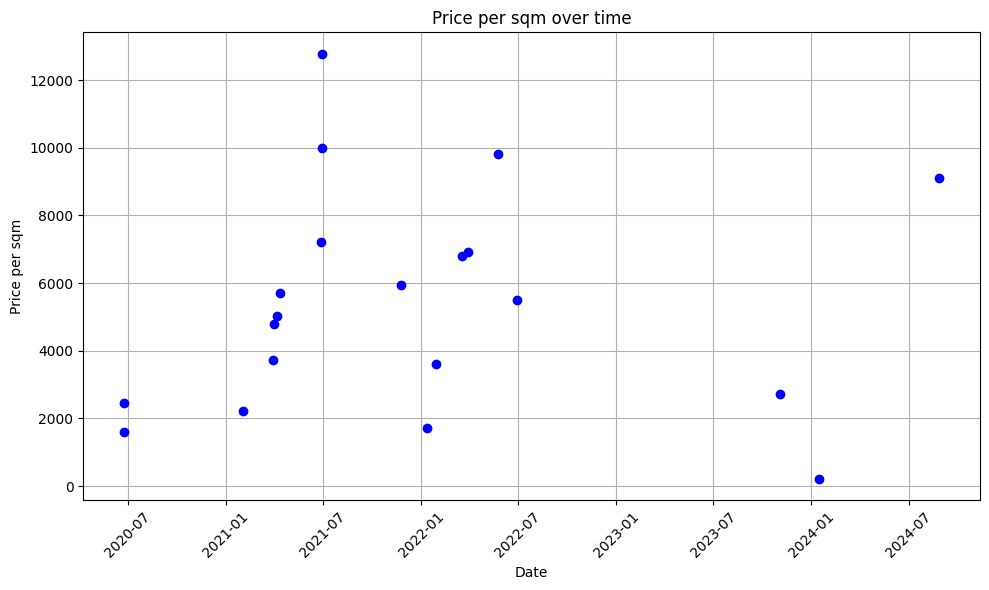

In [1216]:
plot_prices_per_sqm(matched_buildings_from_osm)

### Exercise 11

Replicating the same analysis for Oxford. You do not need to answer all
the questions again, but you should show that your code works for this
new input without the need to modify it. You should use the Fynesse
library for this. Finish by plotting a map of the area and the
correlation you find.

Demonstrate the reusability of your code by executing the same analysis
for Oxford.

In [1198]:
place_name = "Oxford"

latitude = 51.7520
longitude = -1.2577

### Exercise 11 Answer

In [1224]:
%pip uninstall --yes fynesse
%pip install git+https://github.com/sdenyskov/sd995_ads_2024.git

Found existing installation: fynesse 0.1.0
Uninstalling fynesse-0.1.0:
  Successfully uninstalled fynesse-0.1.0
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/sdenyskov/sd995_ads_2024.git to /private/var/folders/tq/f7lcjhp564g26624rbp38l240000gn/T/pip-req-build-arrnk3zz
  Running command git clone --filter=blob:none --quiet https://github.com/sdenyskov/sd995_ads_2024.git /private/var/folders/tq/f7lcjhp564g26624rbp38l240000gn/T/pip-req-build-arrnk3zz
  Resolved https://github.com/sdenyskov/sd995_ads_2024.git to commit e95f27e8445c505d8dfcd3a4352672778d2dd8af
  Preparing metadata (setup.py) ... done
  Created wheel for fynesse: filename=fynesse-0.1.0-py3-none-any.whl size=7060 sha256=5879127f5c50d77ead88e1c6c49d2507197e7339c23c6be3a1b619e652a007e1
  Stored in directory: /private/var/folders/tq/f7lcjhp564g26624rbp38l240000gn/T/pip-ephem-wheel-cache-6b3mz268/wheels/3c/89/03/7b7d5f4887f9d2568c1996e5bc272e3e23ab7406662c635b84
Successfully built

In [1240]:
import fynesse

/var/folders/tq/f7lcjhp564g26624rbp38l240000gn/T/ipykernel_8790/825762988.py:6: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  all_buildings_from_osm = ox.geometries_from_bbox(north, south, east, west, tags = {'building': True})
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/osmnx/geometries.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return features.features_from_bbox(north, south, east, west, tags=tags)
/Library/Frameworks/Python.framework/Versions/3.10/lib/

-0.1022662260580402


/var/folders/tq/f7lcjhp564g26624rbp38l240000gn/T/ipykernel_8790/3737116293.py:6: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  graph = ox.graph_from_bbox(north, south, east, west)
/var/folders/tq/f7lcjhp564g26624rbp38l240000gn/T/ipykernel_8790/3737116293.py:6: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  graph = ox.graph_from_bbox(north, south, east, west)


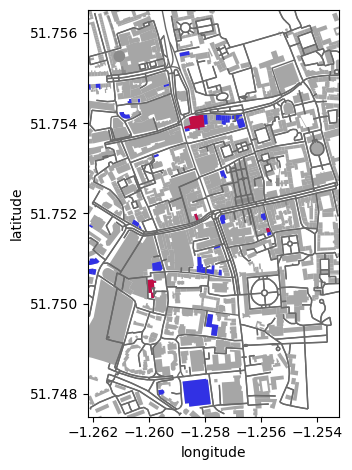

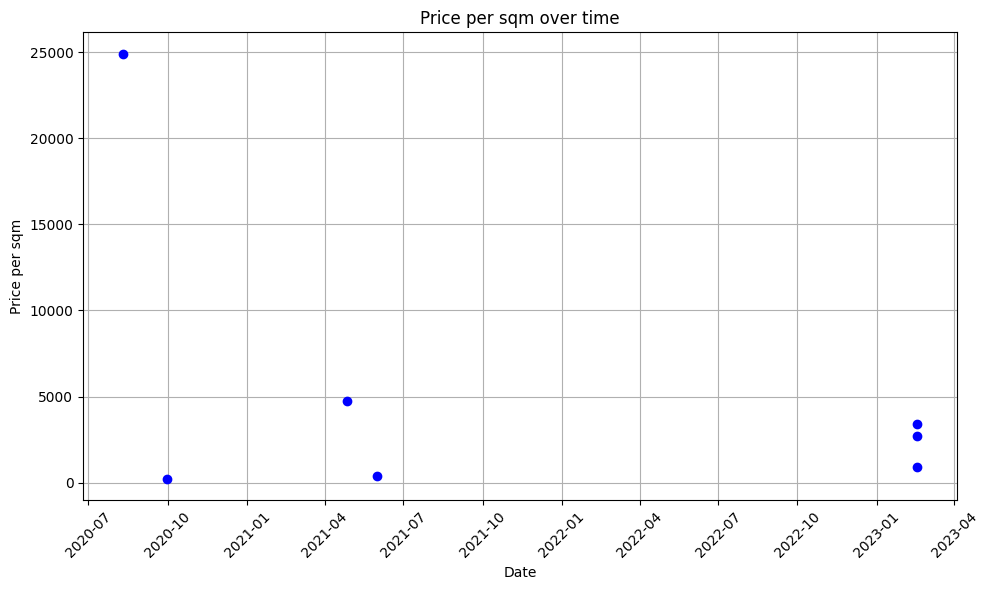

In [1236]:
bounds = get_bounds(latitude, longitude, 1)
north, south, west, east = bounds

all_houses_from_db = get_houses_in_the_area(cursor, bounds).drop_duplicates(subset=all_houses_from_db.columns.difference(['db_id']))
all_buildings_from_osm = get_all_buildings_from_osm(bounds)
valid_buildings_from_osm = filter_buildings_from_osm(all_buildings_from_osm.copy())
matched_buildings_from_osm = match_buildings_from_osm(valid_buildings_from_osm, all_houses_from_db)
corr = matched_buildings_from_osm["price"].corr(matched_buildings_from_osm["area_m2"])

print(corr)
plot_buildings(bounds, all_buildings_from_osm, valid_buildings_from_osm, matched_buildings_from_osm)
plot_prices_per_sqm(matched_buildings_from_osm)

In [1239]:
bounds = fynesse.access.get_bounds(latitude, longitude, 1)
north, south, west, east = bounds

all_houses_from_db = fynesse.access.get_houses_in_the_area(cursor, bounds).drop_duplicates(subset=all_houses_from_db.columns.difference(['db_id']))
all_buildings_from_osm = fynesse.access.get_all_buildings_from_osm(bounds)
valid_buildings_from_osm = fynesse.access.filter_buildings_from_osm(all_buildings_from_osm.copy())
matched_buildings_from_osm = fynesse.address.match_buildings_from_osm(valid_buildings_from_osm, all_houses_from_db)
corr = matched_buildings_from_osm["price"].corr(matched_buildings_from_osm["area_m2"])

print(corr)
fynesse.assess.plot_buildings(bounds, all_buildings_from_osm, valid_buildings_from_osm, matched_buildings_from_osm)
fynesse.assess.plot_prices_per_sqm(matched_buildings_from_osm)

AttributeError: module 'fynesse.access' has no attribute 'get_bounds'

In [ ]:
"""
address.kmeans_clusters(df, n_clusters, normalise)
address.extend_feature_df(df, locations_dict, clusters)
assess.plot_clusters(clustered_locations)
access.normalise_df(data)
address.distance(lat1, lon1, lat2, lon2)
address.get_distance_matrix_df(osm_feature_counts_df_coor)
assess.plot_distance_matrix_df(distance_matrix_df, locations)
assess.plot_correlation_matrix(correlation_matrix)

access.get_bounds(latitude, longitude, box_dim_km)
access.get_houses_in_the_area(cursor, bounds)
access.get_all_buildings_from_osm(bounds)
access.filter_buildings_from_osm(all_buildings_from_osm)
assess.plot_buildings(bounds, place_name, layer1, layer2=None, layer3=None)
address.capitalize(x)
address.match_buildings_from_osm(valid_buildings_from_osm, all_houses_from_db)
assess.plot_prices_per_sqm(matched_buildings_from_osm)
"""


## Conclusions

You should find some of the code you wrote above useful in your final
assessment. Make sure you wrote the code to be reusable and efficient,
and do include it in your Fynesse library. The functions you are
particularly likely to reuse are the OSM feature search, and map
visualisation functions.

### Exercise 12

Add relevant code to your Fynesse library. Demonstrate this was
successful by installing your library below and calling at least two
example functions.

### Exercise 12 Answer

## Thanks!

For more information on these subjects and more you might want to check
the following resources.

-   book: [The Atomic
    Human](https://www.penguin.co.uk/books/455130/the-atomic-human-by-lawrence-neil-d/9780241625248)
-   twitter: [@lawrennd](https://twitter.com/lawrennd)
-   podcast: [The Talking Machines](http://thetalkingmachines.com)
-   newspaper: [Guardian Profile
    Page](http://www.theguardian.com/profile/neil-lawrence)
-   blog:
    [http://inverseprobability.com](http://inverseprobability.com/blog.html)

## References